Empty DataFrame
Columns: [Sector, Size of IO, streamid, block_bio_queue, block_getrq, nvme_sq, block_rq_complete]
Index: []
0
2937670
2937670
원 데이터 ADF Statistic: 0.366
원 데이터 p-value: 0.980


C:\Users\jsm97\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\jsm97\anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jsm97\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\jsm97\anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jsm97\anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning

       order           AIC
12  p1 d1 q2 -13646.092019
19  p2 d1 q1 -13646.071000
20  p2 d1 q2 -13644.164982
11  p1 d1 q1 -13639.582590
22  p2 d2 q1 -13597.618379
18  p2 d1 q0 -13596.624479
8   p0 d2 q2 -13595.919053
7   p0 d2 q1 -13595.848946
14  p1 d2 q1 -13592.457840
15  p1 d2 q2 -13592.203845
23  p2 d2 q2 -13587.901974
5   p0 d1 q2 -13535.703743
17  p2 d0 q1 -13522.602476
21  p2 d2 q0 -13522.245099
10  p1 d1 q0 -13510.997871
4   p0 d1 q1 -13474.374028
3   p0 d1 q0 -13411.138103
13  p1 d2 q0 -13411.027111
16  p2 d0 q0 -13300.925925
6   p0 d2 q0 -13078.076796
9   p1 d0 q0 -12832.688758
2   p0 d0 q2  -4840.576786
1   p0 d0 q1  -3515.790915
0   p0 d0 q0  -2142.065668
                              ARIMA Model Results                              
Dep. Variable:     D.block_rq_complete   No. Observations:                  999
Model:                  ARIMA(1, 1, 2)   Log Likelihood                6828.046
Method:                        css-mle   S.D. of innovations              0.000
Date:

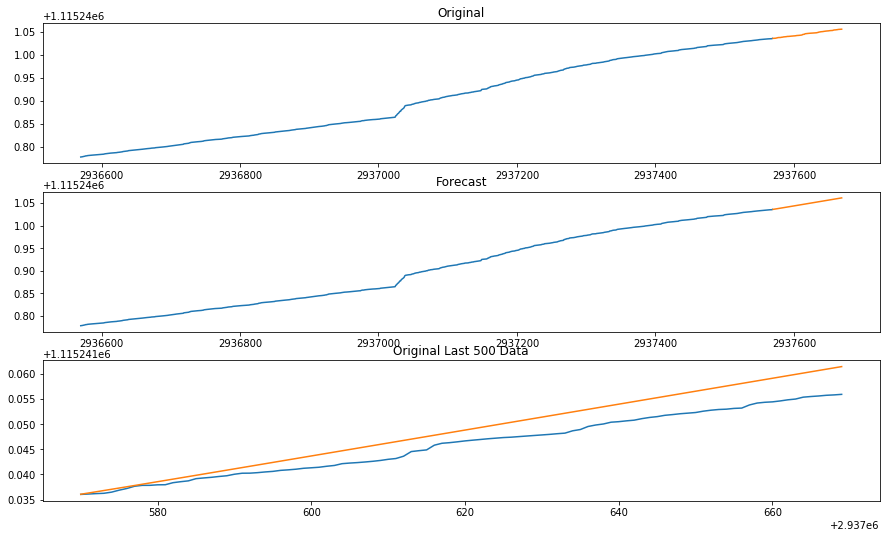

In [67]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
%matplotlib inline
import time

def main():
    data = pd.read_csv("C:/Users/jsm97/Desktop/raw194.csv")
    data = data.copy()
    zero_data = data[data['block_rq_complete']==0]
    print(zero_data)
    print(len(zero_data))
    data = data[data['block_rq_complete']!=0]
    data = data[data['nvme_sq']!=0]
    data = data.dropna()
    print(len(data))
    data = data['block_rq_complete']

    #data = data[data<0.1]
    data = data.reset_index(drop=True)
    
    total=len(data)
    print(total)
    data1=data[total-1100:total-100]

    # P-value Check
    #start = time.time()
    result = adfuller(data1)
    print(f'원 데이터 ADF Statistic: {result[0]:.3f}')
    print(f'원 데이터 p-value: {result[1]:.3f}')
    #data1 = data1.diff().dropna()
    #reslut = adfuller(data1)
    #print(f'1차 차분 ADF Statistic: {result[0]:.3f}')
    #print(f'1차 차분 p-value: {result[1]:.3f}')

    #print("time : ",time.time()-start)
    
    # ARIMA Parameter Select
    list_arima = my_auto_arima(data1, [3,3,3])
    print(list_arima)

    # ARIMA Model
    model = ARIMA(data1, order=(1,1,2))
    model_fit = model.fit()
    print(model_fit.summary())
    forecast = model_fit.forecast(steps=100)[0]
    #forecast = model_fit.predict(start= 0,end = 500)
    forecast = pd.DataFrame(forecast)
    forecast.index=range(total-100,total)
    print("forecast")
    print(forecast)
    test_data = data[total-100:]
    print("Original")
    print(test_data)
    #test_data1 = data[total-5000:total-19500]

    # plot
    plt.figure(figsize=(15,15))
    plt.subplot(5,1,1)
    plt.title("Original")
    plt.plot(data1)
    plt.plot(test_data)
    plt.subplot(5,1,2)
    plt.title("Forecast")
    plt.plot(data1)
    plt.plot(forecast)
    plt.subplot(5,1,3)
    plt.title("Original Last 500 Data")
    plt.plot(test_data)
    plt.plot(forecast)
    #plt.subplot(5,1,4)
    #plt.title("Forecast Last 500 Data")
    #plt.plot(data)
    #plt.subplot(5,1,5)
    #plt.plot(test_data1)
    #plt.plot(forecast)

    # mae
    forecast = np.array(forecast).reshape(-1,1)
    test_data = np.array(test_data).reshape(-1,1)
    error_mean = np.mean(np.abs(test_data - forecast), axis=0)
    print("mae : ",error_mean)

def my_auto_arima(data, order,sort = 'AIC'):
    order_list = []
    aic_list = []
    bic_lsit = []
    for p in range(order[0]):
        for d in range(order[1]):
            for q in range(order[2]):
                model = ARIMA(data, order=(p,d,q))
                try:
                    model_fit = model.fit()
                    c_order = f'p{p} d{d} q{q}'
                    aic = model_fit.aic
                    bic = model_fit.bic
                    order_list.append(c_order)
                    aic_list.append(aic)
                    bic_list.append(bic)
                except:
                    pass
    result_df = pd.DataFrame(list(zip(order_list, aic_list)),columns=['order','AIC'])
    result_df.sort_values(sort, inplace=True)
    return result_df
main()
